In [6]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import curve_fit
from numpy import exp
from astropy.modeling import models, fitting
from scipy import ndimage
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

In [7]:
def redshift(vel):
    return vel/300000.0
    #This function also represent the line dispersion in A through a velocity dispersion in km/s also taking into account 
    # that the spectrograph itself already broadens the emission lines. This way you automatically fit for the intrinsic line dispersion
def line_width(vel_sigma,rest_line,inst_res_fwhm=2.4):
    sigma = vel_sigma/(300000.0-vel_sigma)*rest_line
    return np.sqrt(sigma**2+(inst_res_fwhm/2.354)**2)

def gauss(wave,amplitude,vel,vel_sigma, rest_wave):
    line = (amplitude)*exp(-(wave-(rest_wave*(1+redshift(vel))))**2/(2*(line_width(vel_sigma, rest_wave))**2))
    return line                         
    # Here we couple the HB and OIII doublet together using the gaussian function defined before
def Hb_O3_gauss(wave,amp_Hb,amp_OIII5007,vel,vel_sigma):
    Hb = gauss(wave,amp_Hb,vel,vel_sigma,4861.33)
    OIII_4959 = (0.33)*gauss(wave,amp_OIII5007,vel,vel_sigma,4958.9)
    OIII_5007 = gauss(wave,amp_OIII5007,vel,vel_sigma,5006.8)
    return Hb + OIII_4959 + OIII_5007
    # Same as before but fore the Fe doublet
def Fe_doublet_gauss(wave,amp_Fe4923,amp_Fe5018,vel,vel_sigma):
    Fe_4923 = gauss(wave,amp_Fe4923,vel,vel_sigma,4923)
    Fe_5018 = gauss(wave,amp_Fe5018,vel,vel_sigma,5018)
    return Fe_4923+Fe_5018

def Hb_Fe_doublet_gauss(wave,amp_Hb,amp_Fe5018,vel,vel_sigma):
    Hb = gauss(wave,amp_Hb,vel,vel_sigma,4861.33)
    Fe_4923 = 0.81*gauss(wave,amp_Fe5018,vel,vel_sigma,4923)
    Fe_5018 = gauss(wave,amp_Fe5018,vel,vel_sigma,5018)
    return Hb+Fe_4923+Fe_5018

def full_gauss(p,wave,data,error):
    (amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c) = p 
    narrow_OIII = Hb_O3_gauss(wave,amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII)
    broad_OIII = Hb_O3_gauss(wave,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br)
    Hb_broad1 = Hb_Fe_doublet_gauss(wave,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1)
    #Hb_broad2 = 0 
    Hb_broad2 = Hb_Fe_doublet_gauss(wave,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2) 
    cont = (wave/1000.0)*m+c
    return (narrow_OIII+broad_OIII+Hb_broad1+Hb_broad2+cont-data)/error


In [8]:
hdu = fits.open('HE0232-0900.wo_absorption.fits')
qso_data = hdu[0].data
qso_error = hdu[1].data
qso_header = hdu[0].header
wavestart = qso_header['CRVAL3']
wavint = qso_header['CD3_3']
wave = wavestart+np.arange(qso_data.shape[0])*wavint 

In [9]:
x = wave
y = qso_data[:,51,67] # I set the central position manual here, but one can also search for maximum light in principle
y_err = qso_error[:,51,67]

In [10]:
z = 0.043143
k = z+1
select = (x>4750*k) & (x<5090*k)
popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=[2,40,12942,50.0,5,5,12842,100.0,5,1,12942,1000.0,1,1,12942,1000.0,-0.001,0.1],args=(x[select],y[select],y_err[select]),maxfev = 10000000)                                                    
print(popt_full_fit)

[  2.98299754e+00   3.42594963e+01   1.29034186e+04   1.34572813e+02
   7.83542458e-01   1.81459193e+01   1.28271934e+04   2.83263811e+02
   7.39972055e+00   1.08600434e+00   1.29485746e+04   2.16583130e+03
   5.19666183e-01   4.69836316e-01   1.08458661e+04   5.20354389e+02
  -4.11164681e+00   2.91123812e+01]


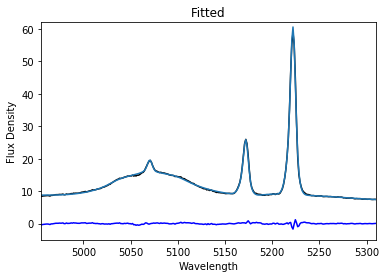

In [11]:
plt.xlim([4750*k,5090*k])
plt.ylim([-5,62])
plt.plot(x[select],y[select],'k-')
fit = full_gauss(popt_full_fit,x[select],y[select],y_err[select])*(y_err[select])+y[select]
plt.plot(x[select],fit,label='fit')
residual = y[select] - fit
plt.plot(x[select],residual,'b-')
plt.legend
plt.title('Fitted')
plt.xlabel('Wavelength')
plt.ylabel('Flux Density')
plt.show()

In [12]:
from scipy import stats
stats.ks_2samp(y[select], fit)

Ks_2sampResult(statistic=0.038732394366197187, pvalue=0.98143248689807783)